- convolution reduces spatial information (2D images or 1D time series) to components by means of filters. The filters have usually been trained based on a large number of examples, describing features that these examples have in common. The result of the convolutional layers is then a representation that describes how much of each feature has been in the original image.
- "One-way streets" such as max- and average pooling aside, this process could also be used the other way round to generate images using "deconvolution"
- Lets assume a training set consists of single pixel images, which color is drawn from a 3D normal distribution centered around the color orange. The "generator" G() does not know this distribution, but turns uniform random input drawn from a distribution z into colors. The "discriminator" has learned the original distribution and can say "hot" (yes) or "cold" (no) and anything in between. The network can now use this feedback to improve the generator to better match the true distribution. At the same time, we can use knowledge of the fact that generated images are fake to improve the discriminator. 

Formally, the optimization problem is to 

maximize D performance while minimizing generator error

min_G max_D 

A generator is using deconvolution to turn a seed of noise into an image. Initially, the generated images are just noise, but will eventually be distributed as the training set. The generator itself is never trained by itself, which is indicated by all parameters colored in light gray, but only when part of an "adversarial" network, see below. As this network is trained, the generator gets better and better, here showing the output after zero and 2000 iterations. 

<center>
    <img src="figs/GAN_generator.svg" width="60%">
</center>

We use a "discriminator" to decide whether an image is following the desired distribution, i.e. like the training set, or a generated image. We can train this discriminator by using two batches of equal size, one of which contains training images, the other generated images. The generated images are labeled by a zero, the training images by a one.

<center>
    <img src="figs/GAN_discriminator.svg" width="50%">
</center>

As the generator gets better, the discriminator will get presented with better and better generated images, becoming more and more sophisticated. Here, the training set at 0 and after 2000 iterations of training the generator are shown.


A GAN consists of a generator and a discriminator network that are connected in series and can be used individually. When training the GAN, the generator pretends that images it generates are real images, which leads to a loss if the discriminator detects the fake image. In order to prevent this loss from backpropagating into the discriminator, all discriminator parameters are locked during training, which is indicated by all parameters of the discriminator shown in light gray.  

<center>
    <img src="figs/GAN_adversarial.svg" width="75%">
</center>

In [ ]:
test=np.random.uniform(-1.0, 1.0, size=[16, 100])
test.shape
for I in range(4):
    for J in range(4):
        plt.subplot(4,4,I*4+J+1)
        plt.imshow(test[I*4+J,:].reshape(10,10),cmap='gray')
        plt.axis('off')
#plt.tight_layout()        
plt.show()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 256)       

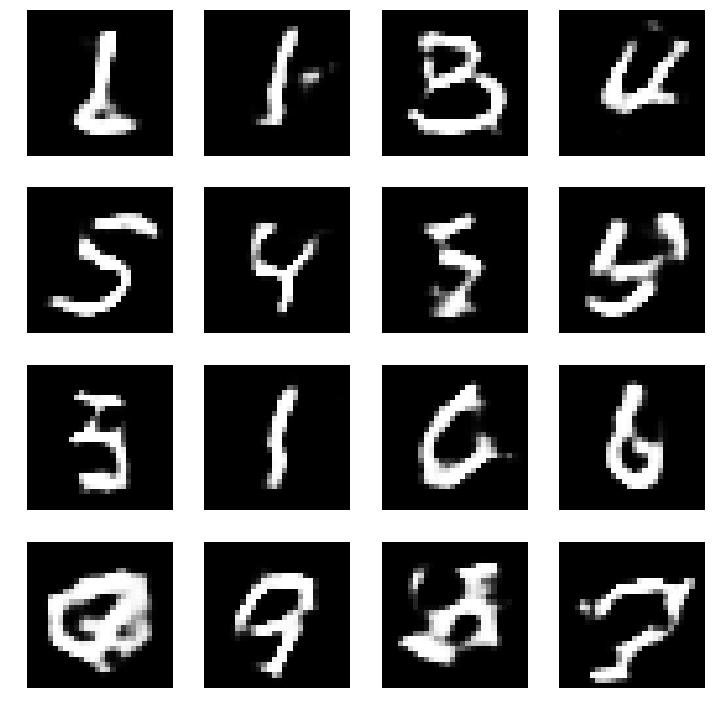

In [16]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        (x_train, Y_train), (x_test, Y_test) = mnist.load_data()
        x_train = x_train.reshape(60000,28,28,1)
        x_test = x_test.reshape(10000, 28,28,1)
        self.x_train = x_train.astype('float32')
        self.x_test = x_test.astype('float32')
        # normalize
        #
        self.x_train /= 255
        self.x_test /= 255
        # convert class vectors to binary class matrices
        self.y_train = np_utils.to_categorical(Y_train, 10)
        self.y_test = np_utils.to_categorical(Y_test, 10)
        

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            self.discriminator.trainable = True
            d_loss = self.discriminator.train_on_batch(x, y)
            self.discriminator.trainable = False
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    timer = ElapsedTimer()
    mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=50)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

<img src="figs/GAN_mnist.gif">

First trial, without locking discriminator. Second trial with locking discriminator. 

In [18]:
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=50)

0: [D loss: 0.697947, acc: 0.519531]  [A loss: 0.760974, acc: 0.359375]
1: [D loss: 0.695951, acc: 0.523438]  [A loss: 0.953906, acc: 0.125000]
2: [D loss: 0.677682, acc: 0.556641]  [A loss: 0.753326, acc: 0.371094]
3: [D loss: 0.696532, acc: 0.544922]  [A loss: 0.921155, acc: 0.160156]
4: [D loss: 0.667644, acc: 0.589844]  [A loss: 0.735313, acc: 0.445312]
5: [D loss: 0.707076, acc: 0.515625]  [A loss: 0.959221, acc: 0.121094]
6: [D loss: 0.673640, acc: 0.576172]  [A loss: 0.754499, acc: 0.367188]
7: [D loss: 0.689126, acc: 0.539062]  [A loss: 0.878590, acc: 0.171875]
8: [D loss: 0.686064, acc: 0.554688]  [A loss: 0.813754, acc: 0.257812]
9: [D loss: 0.684674, acc: 0.568359]  [A loss: 0.903288, acc: 0.156250]
10: [D loss: 0.689662, acc: 0.521484]  [A loss: 0.781430, acc: 0.296875]
11: [D loss: 0.699630, acc: 0.521484]  [A loss: 0.935372, acc: 0.105469]
12: [D loss: 0.688363, acc: 0.539062]  [A loss: 0.735295, acc: 0.437500]
13: [D loss: 0.701864, acc: 0.535156]  [A loss: 0.933866, acc